# TP Final

Segunda Parte

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics

from torch.utils.tensorboard import SummaryWriter

## Visualización de los datos

El Dataset que voy a usar es 

https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

Es un dataset de cartas de Poker 224 X 224 X 3 en formato jpg. \
Hay solo una carta en cada imagen y ocupa al menos el 50%. \
Hay 7624 imagens en entrenamiento, 265 en Test y 265 en validacion. \
La idea es Entrenar un modelo de clasificacion que a partir de una imagen de una carta pueda decirnos cual es. \
Yo ya tengo el directorio bajado localmente.


Cargo los datos e imprimo una imagen de cada clase etiquetada

In [3]:
# Definiciones iniciales
# Para Inception necesito que las imagenes sean 300 x 300
CANTIDAD_CLASES = 53
ANCHO_IMAGENES = 300
ALTO_IMAGENES = 300

In [4]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root='data_Cards/train', transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='data_Cards/test', transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)

### Inception V3
Defino un modelo  Inception V3 en el cual reemplazo la capa Fully Coneected por una con un numero de salidas igual \
al numero de clases de mi dataset

In [5]:
incV3_model = torchvision.models.inception_v3()
incV3_model.modules

last_layer_in_features = incV3_model.fc.in_features
incV3_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
if torch.cuda.is_available():
    incV3_model.to("cuda")
torchsummary.summary(incV3_model, (3, 300, 300))


d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\cv1\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [6]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None, checkpoint_fpath=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    # Esto lo agrego para poder usar un modelo previamente entrenado y seguir desde ahí.
    if checkpoint_fpath:
        checkpoint = torch.load(checkpoint_fpath)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to('cuda')

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()            
            output, _ = model(train_data.float()) # Inception devuelve dos cosas. Solo necesito la primera. Por el aux_logits
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

Entreno el modelo

In [16]:
noaug_inc_v3_model = torchvision.models.inception_v3()
last_layer_in_features = noaug_inc_v3_model.fc.in_features
noaug_inc_v3_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

noaug_inc_v3_optimizer = torch.optim.Adam(noaug_inc_v3_model.parameters(), lr=0.0001)
noaug_inc_v3_loss = torch.nn.CrossEntropyLoss()
noaug_inc_v3_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_inc_v3_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_inc_v3_writer = {"train": SummaryWriter(log_dir="data_cards/noaug_inc_v3_train"),
                "valid": SummaryWriter(log_dir="data_cards/noaug_inc_v3_valid")}

history = train(noaug_inc_v3_model,
                noaug_inc_v3_optimizer,
                noaug_inc_v3_loss,
                noaug_inc_v3_metric,
                noaug_inc_v3_data,
                20,
                noaug_inc_v3_writer,
                None)

state = {
        'epoch': 20,
        'state_dict': noaug_inc_v3_model.state_dict(),
        'optimizer': noaug_inc_v3_optimizer.state_dict(),
}
savepath='checkpoint.noaug_inc_v3_20'
torch.save(state,savepath)

Epoch: 1/20 - Train loss 3.753936 - Train Accuracy 0.053125 - Valid Loss 3.351083 - Valid Accuracy 0.071875
Epoch: 2/20 - Train loss 3.136599 - Train Accuracy 0.114844 - Valid Loss 2.886376 - Valid Accuracy 0.096875
Epoch: 3/20 - Train loss 2.825582 - Train Accuracy 0.171745 - Valid Loss 2.685642 - Valid Accuracy 0.156250
Epoch: 4/20 - Train loss 2.596647 - Train Accuracy 0.227865 - Valid Loss 2.430767 - Valid Accuracy 0.267014
Epoch: 5/20 - Train loss 2.374662 - Train Accuracy 0.285677 - Valid Loss 2.404760 - Valid Accuracy 0.200347
Epoch: 6/20 - Train loss 2.150158 - Train Accuracy 0.347266 - Valid Loss 2.281863 - Valid Accuracy 0.288194
Epoch: 7/20 - Train loss 1.940015 - Train Accuracy 0.420833 - Valid Loss 2.078780 - Valid Accuracy 0.353819
Epoch: 8/20 - Train loss 1.768269 - Train Accuracy 0.470964 - Valid Loss 1.926911 - Valid Accuracy 0.378819
Epoch: 9/20 - Train loss 1.598600 - Train Accuracy 0.529687 - Valid Loss 1.520621 - Valid Accuracy 0.536458
Epoch: 10/20 - Train loss 1.

Realizo gráficas del resultado del entrenamiento para visualizar el comportamiento de las métricas a lo largo de las epocas.

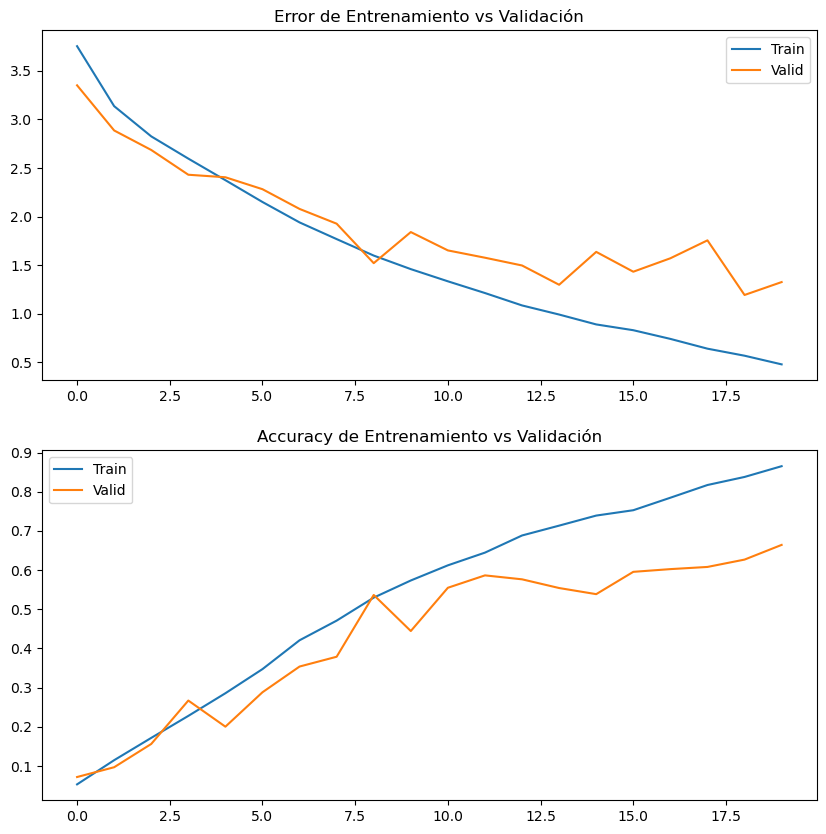

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

Quizas se pueda beneficiar de más épocas.


In [18]:
noaug_inc_v3_model = torchvision.models.inception_v3()
last_layer_in_features = noaug_inc_v3_model.fc.in_features
noaug_inc_v3_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
noaug_inc_v3_model.aux_logits = True

noaug_inc_v3_optimizer = torch.optim.Adam(noaug_inc_v3_model.parameters(), lr=0.0001)
noaug_inc_v3_loss = torch.nn.CrossEntropyLoss()
noaug_inc_v3_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
noaug_inc_v3_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_inc_v3_writer = {"train": SummaryWriter(log_dir="data_cards/noaug_inc_v3_train"),
                "valid": SummaryWriter(log_dir="data_cards/noaug_inc_v3_valid")}

history = train(noaug_inc_v3_model,
                noaug_inc_v3_optimizer,
                noaug_inc_v3_loss,
                noaug_inc_v3_metric,
                noaug_inc_v3_data,
                20,
                noaug_inc_v3_writer,
                'checkpoint.noaug_inc_v3_20')

state = {
        'epoch': 20,
        'state_dict': noaug_inc_v3_model.state_dict(),
        'optimizer': noaug_inc_v3_optimizer.state_dict(),
}
savepath='checkpoint.noaug_inc_v3_40'
torch.save(state,savepath)

Epoch: 1/20 - Train loss 0.401792 - Train Accuracy 0.884115 - Valid Loss 1.579504 - Valid Accuracy 0.627083
Epoch: 2/20 - Train loss 0.360866 - Train Accuracy 0.898828 - Valid Loss 1.342504 - Valid Accuracy 0.670833
Epoch: 3/20 - Train loss 0.302095 - Train Accuracy 0.916146 - Valid Loss 1.308496 - Valid Accuracy 0.696181
Epoch: 4/20 - Train loss 0.273448 - Train Accuracy 0.922005 - Valid Loss 1.327868 - Valid Accuracy 0.673958
Epoch: 5/20 - Train loss 0.240775 - Train Accuracy 0.932031 - Valid Loss 1.342114 - Valid Accuracy 0.674306
Epoch: 6/20 - Train loss 0.225069 - Train Accuracy 0.937760 - Valid Loss 1.186989 - Valid Accuracy 0.730556
Epoch: 7/20 - Train loss 0.200899 - Train Accuracy 0.946745 - Valid Loss 1.305761 - Valid Accuracy 0.721528
Epoch: 8/20 - Train loss 0.231798 - Train Accuracy 0.937760 - Valid Loss 1.501631 - Valid Accuracy 0.673611
Epoch: 9/20 - Train loss 0.260513 - Train Accuracy 0.920964 - Valid Loss 1.567586 - Valid Accuracy 0.661111
Epoch: 10/20 - Train loss 0.

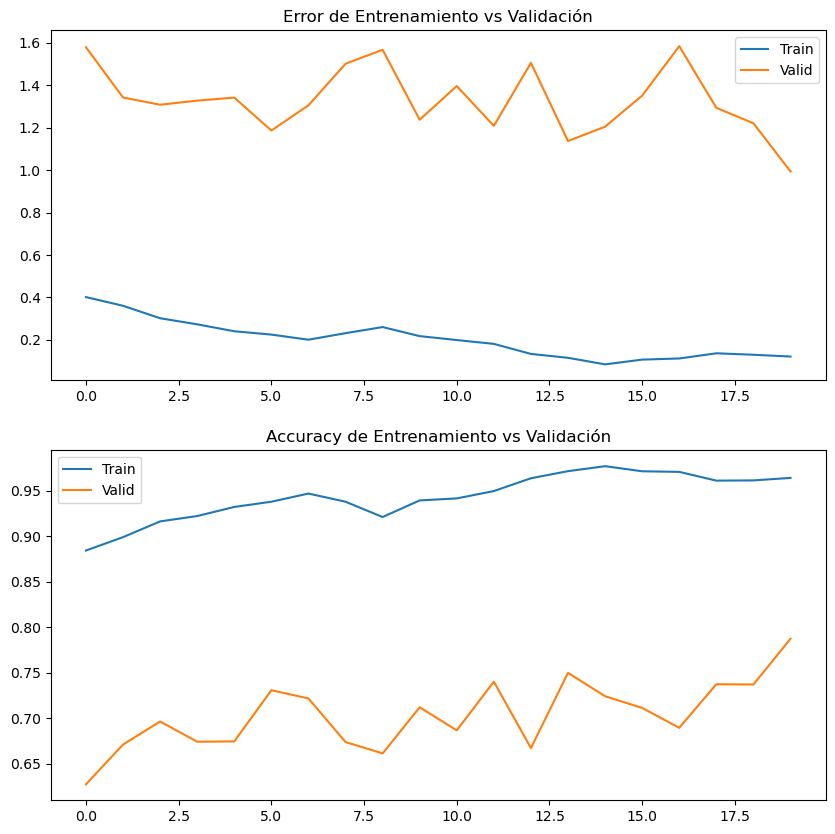

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

Hay sobreajuste. Quizás se pueda mejorar con Data Augmentation

Ahora voy a probar usando pesos preentrenados de Inception V3 \
A los que le agrego unas ultimas capas sencillas

In [25]:
inc_v3_PT_model = torchvision.models.inception_v3(pretrained=True)
for param in inc_v3_PT_model.parameters():
    param.requires_grad = False #Freezing all the layers and changing only the below layers
inc_v3_PT_model.avgpool = torch.nn.AdaptiveAvgPool2d(output_size=(1,1))
inc_v3_PT_model.fc = torch.nn.Sequential(torch.nn.Flatten(),
                        torch.nn.Linear(2048,128),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(0.2),
                        torch.nn.Linear(128,CANTIDAD_CLASES))
inc_v3_PT_model.aux_logits = True
inc_v3_PT_loss = torch.nn.CrossEntropyLoss()
inc_v3_PT_optimizer = torch.optim.Adam(inc_v3_PT_model.parameters(), lr= 1e-3)

inc_v3_PT_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
inc_v3_PT_data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

inc_v3_PT_writer = {"train": SummaryWriter(log_dir="data_cards/inc_v3_PT_train"),
                "valid": SummaryWriter(log_dir="data_cards/inc_v3__PT_valid")}

history = train(inc_v3_PT_model,
                inc_v3_PT_optimizer,
                inc_v3_PT_loss,
                inc_v3_PT_metric,
                inc_v3_PT_data,
                20,
                inc_v3_PT_writer,
                None)

state = {
        'epoch': 20,
        'state_dict': inc_v3_PT_model.state_dict(),
        'optimizer': inc_v3_PT_optimizer.state_dict(),
}
savepath='checkpoint.inc_v3_PT_20'
torch.save(state,savepath)

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\cv1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\cv1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


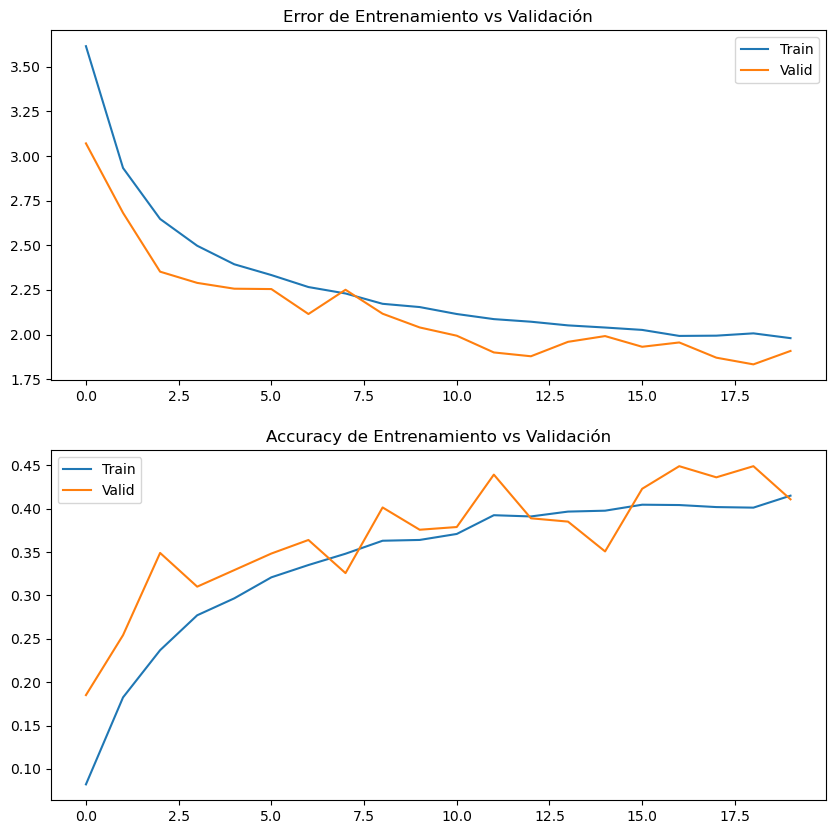

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

### Inception V3 Con Data augmentation
Aca voy a entrenar le mismo modelo pero con data aumentada con transformaciones

In [8]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        # torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomRotation(degrees=(0,180)),
                        torchvision.transforms.RandomPerspective(0.4),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.8, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.3, hue=0.3),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

aug_train_set = torchvision.datasets.ImageFolder(root='data_Cards/train', transform=aug_data_transforms)
aug_valid_set = torchvision.datasets.ImageFolder(root='data_Cards/valid', transform=data_transforms)

aug_train_loader = torch.utils.data.DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_valid_loader = torch.utils.data.DataLoader(aug_valid_set, batch_size=64, shuffle=True)

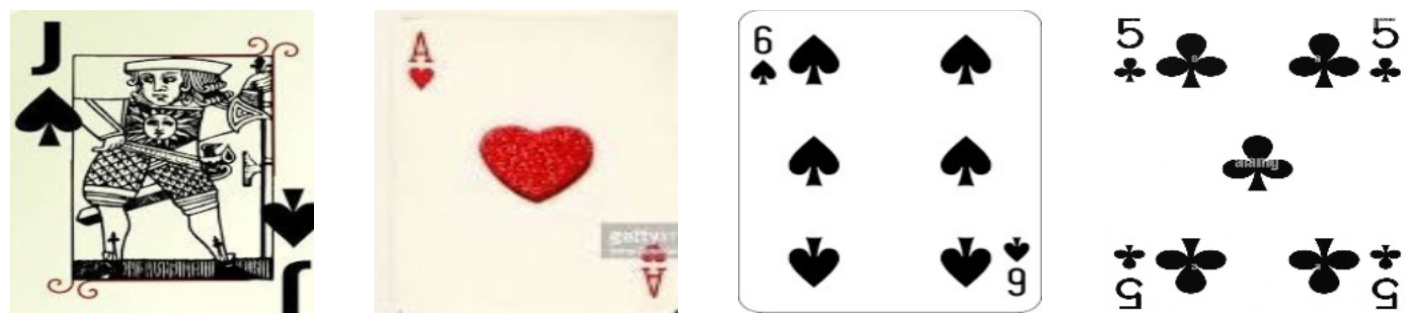

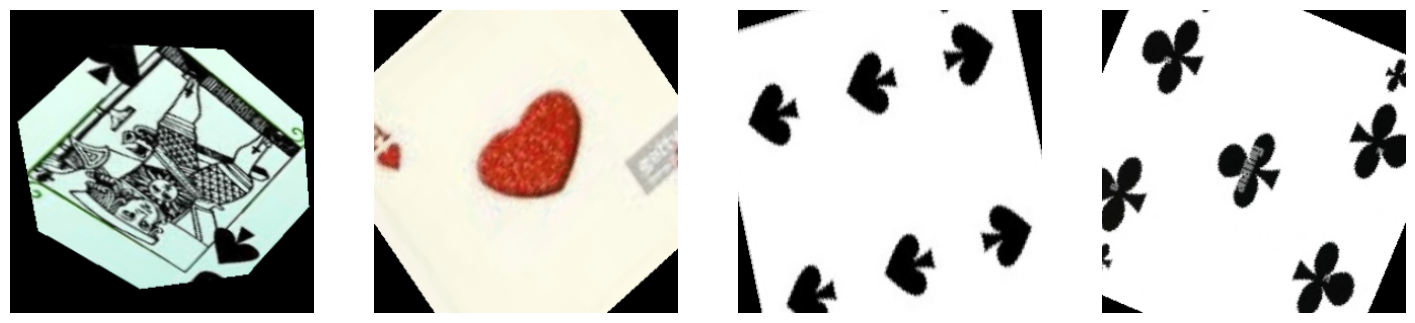

In [13]:
images_ids = np.random.randint(low=0, high=len(train_set), size=4)

# Ploteo las imagenes sin augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

# Ploteo las mismas imagenes con augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(aug_train_set2[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

In [15]:
aug_inc_v3_model = torchvision.models.inception_v3()
last_layer_in_features = aug_inc_v3_model.fc.in_features
aug_inc_v3_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

aug_inc_v3_optimizer = torch.optim.Adam(aug_inc_v3_model.parameters(), lr=0.0001)
aug_inc_v3_loss = torch.nn.CrossEntropyLoss()
aug_inc_v3_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
aug_inc_v3_data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_inc_v3_writer = {"train": SummaryWriter(log_dir="data_cards/noaug_inc_v3_train"),
                "valid": SummaryWriter(log_dir="data_cards/noaug_inc_v3_valid")}

history = train(aug_inc_v3_model,
                aug_inc_v3_optimizer,
                aug_inc_v3_loss,
                aug_inc_v3_metric,
                aug_inc_v3_data,
                40,
                aug_inc_v3_writer,
                None)

state = {
        'epoch': 40,
        'state_dict': aug_inc_v3_model.state_dict(),
        'optimizer': aug_inc_v3_optimizer.state_dict(),
}
savepath='checkpoint.aug_inc_v3_40'
torch.save(state,savepath)

Epoch: 1/40 - Train loss 3.759137 - Train Accuracy 0.048698 - Valid Loss 3.400851 - Valid Accuracy 0.100694
Epoch: 2/40 - Train loss 3.316280 - Train Accuracy 0.084505 - Valid Loss 2.980384 - Valid Accuracy 0.075000
Epoch: 3/40 - Train loss 3.077301 - Train Accuracy 0.120052 - Valid Loss 3.021305 - Valid Accuracy 0.103125
Epoch: 4/40 - Train loss 2.952698 - Train Accuracy 0.138672 - Valid Loss 2.700730 - Valid Accuracy 0.131597
Epoch: 5/40 - Train loss 2.847194 - Train Accuracy 0.165104 - Valid Loss 2.805221 - Valid Accuracy 0.163194
Epoch: 6/40 - Train loss 2.771633 - Train Accuracy 0.184505 - Valid Loss 2.683247 - Valid Accuracy 0.178472
Epoch: 7/40 - Train loss 2.692125 - Train Accuracy 0.210286 - Valid Loss 2.647614 - Valid Accuracy 0.187847
Epoch: 8/40 - Train loss 2.595547 - Train Accuracy 0.236849 - Valid Loss 2.553072 - Valid Accuracy 0.216319
Epoch: 9/40 - Train loss 2.530893 - Train Accuracy 0.246094 - Valid Loss 2.427452 - Valid Accuracy 0.240972
Epoch: 10/40 - Train loss 2.

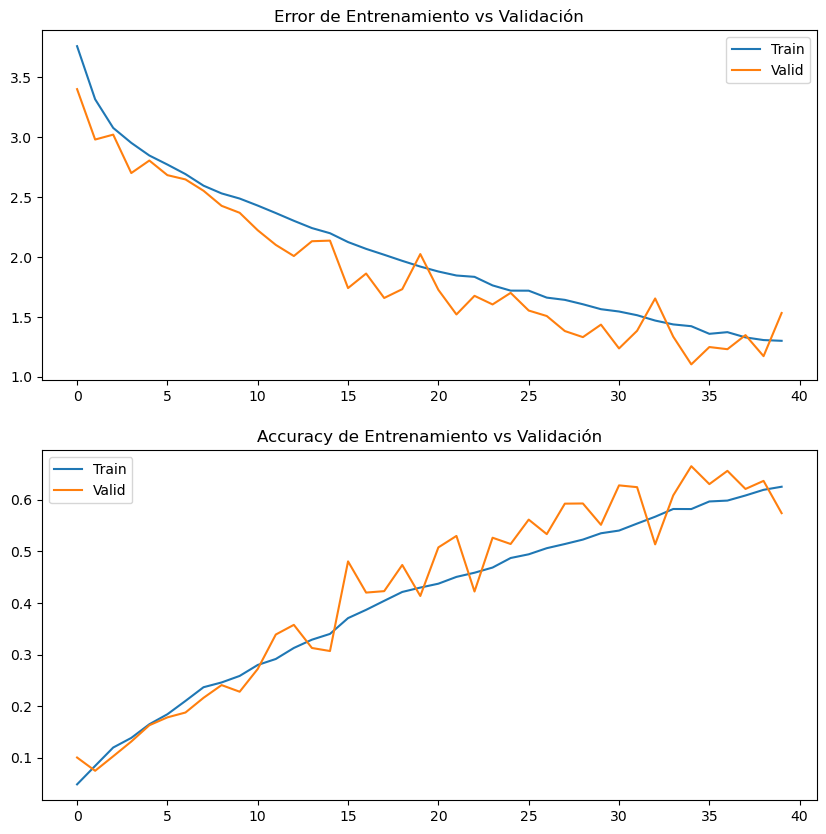

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

Aun no sobreajusta, pero le toma muchas épocas